# GOAL

Examine the copy number states on clonal 3D7 samples predicted by a Gaussian Mixture HMM using similar methods as published papers on WGS anopheles and Plasmodium falciparum datasets, where read coverage in a window is only normalized by GC content. Compare the predictions across 3D7 samples prepared through WGS, gDNA (leukodpleted and unamplified), and sWGA protocols.

In [28]:
import os
import os
import glob
import re
import pandas
from IPython.display import display, HTML

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from hmmlearn import hmm
import scipy.stats
# from sklearn import hmm

In [29]:
pysam_stats_tsv = os.path.abspath(os.getcwd() + "/../../data/pysamstats_gc/3D7_10-T1.12978906.unknown.pysamstats_gc.txt")
pysam_stats_tsv

'/Users/tn6/gitrepo/pf_swga_cnv/data/pysamstats_gc/3D7_10-T1.12978906.unknown.pysamstats_gc.txt'

In [30]:
pysam_stats = pandas.read_csv(pysam_stats_tsv, sep="\t")
pysam_stats = pysam_stats.set_index(["chrom", "pos"])
pysam_stats.index.names  = ["chrom", "pos"]

In [31]:
# chrom5 = pysam_stats[pysam_stats.index.get_level_values("chrom") == "Pf3D7_05_v3"]
# chrom5.describe()

In [32]:
# chrom5.shape

In [33]:
# chrom5.head()

In [34]:
pysam_gc_stats_tsv = os.path.abspath(os.getcwd() + "/../../data/swga.Pf3D7_05_v3.pysamstats.gc.txt")
pysam_gc_stats_tsv

'/Users/tn6/gitrepo/pf_swga_cnv/data/swga.Pf3D7_05_v3.pysamstats.gc.txt'

In [35]:
# Per-position GC content, read coverage.  
# We don't care about properly paired reads here, since there could be 
# inversions, deletions, insertions that alter orientation of read pairs.
pysam_gc = pandas.read_csv(pysam_gc_stats_tsv, sep="\t")
# Indicate the window start position
pysam_gc["window"] =  300 * (pysam_gc.pos // 300)

In [36]:
display(pysam_gc.shape)
display(pysam_gc.head())
display(pysam_gc.describe())

(1317309, 6)

,chrom,pos,gc,reads_all,reads_pp,window
0,Pf3D7_05_v3,1602,32,1,0,1500
1,Pf3D7_05_v3,1603,32,1,0,1500
2,Pf3D7_05_v3,1604,32,1,0,1500
3,Pf3D7_05_v3,1605,32,1,0,1500
4,Pf3D7_05_v3,1606,32,1,0,1500


,pos,gc,reads_all,reads_pp,window
count,1.317309e+06,1.317309e+06,1.317309e+06,1.317309e+06,1.317309e+06
mean,6.831478e+05,1.905715e+01,2.623306e+02,2.507008e+02,6.829983e+05
std,3.806844e+05,6.267258e+00,2.775215e+02,2.640337e+02,3.806844e+05
min,1.602000e+03,1.000000e+00,1.000000e+00,0.000000e+00,1.500000e+03
25%,3.534650e+05,1.400000e+01,1.030000e+02,9.800000e+01,3.534000e+05
50%,6.833370e+05,1.900000e+01,1.840000e+02,1.760000e+02,6.831000e+05
75%,1.012664e+06,2.300000e+01,3.240000e+02,3.100000e+02,1.012500e+06
max,1.342946e+06,5.700000e+01,3.621000e+03,3.509000e+03,1.342800e+06


In [37]:
pysam_gc_win = pysam_gc.groupby("window").agg({'gc': {"gc_win_med": "median", 'gc_win_mean': "mean"},
                                              'reads_all': {"reads_all_win_med": "median", 
                                                            'reads_all_win_mean': "mean"}})
pysam_gc_win.columns = pysam_gc_win.columns.droplevel()
pysam_gc_win["gc_bin"] = 10 * (pysam_gc_win["gc_win_mean"] //10)
pysam_gc_win.head()

/Users/tn6/anaconda3/envs/analysis_py35_mac/lib/python3.5/site-packages/pandas/core/groupby.py:4036: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


,reads_all_win_mean,reads_all_win_med,gc_win_med,gc_win_mean,gc_bin
window,,,,,
1500,1.000000,1.0,33.0,32.980132,30.0
2700,1.687023,2.0,30.0,30.236641,30.0
3000,1.000000,1.0,31.0,31.181818,30.0
4500,1.000000,1.0,31.0,31.124138,30.0
4800,1.000000,1.0,32.0,32.473684,30.0


In [38]:
pysam_gc_win.shape

(4405, 5)

In [39]:
pysam_gc_win.describe()

,reads_all_win_mean,reads_all_win_med,gc_win_med,gc_win_mean,gc_bin
count,4405.000000,4405.000000,4405.000000,4405.000000,4405.000000
mean,261.507023,261.635528,19.086152,19.091481,14.281498
std,273.069246,274.247315,6.060680,5.939678,6.506668
min,1.000000,1.000000,1.000000,1.573333,0.000000
25%,105.080000,104.000000,15.000000,14.663333,10.000000
50%,184.810000,185.000000,19.000000,18.846667,10.000000
75%,321.793333,322.000000,23.000000,22.640000,20.000000
max,3171.200000,3149.000000,50.000000,46.883333,40.000000


In [40]:
# Find the mean reads in each GC Bin
pysam_gc_per_pos_per_win = pysam_gc.reset_index().set_index("window").join(pysam_gc_win[["gc_bin"]])
display(pysam_gc_per_pos_per_win.shape)
display(pysam_gc_per_pos_per_win.head())
display(pysam_gc_per_pos_per_win.describe())

(1317309, 7)

,index,chrom,pos,gc,reads_all,reads_pp,gc_bin
window,,,,,,,
1500,0,Pf3D7_05_v3,1602,32,1,0,30.0
1500,1,Pf3D7_05_v3,1603,32,1,0,30.0
1500,2,Pf3D7_05_v3,1604,32,1,0,30.0
1500,3,Pf3D7_05_v3,1605,32,1,0,30.0
1500,4,Pf3D7_05_v3,1606,32,1,0,30.0


,index,pos,gc,reads_all,reads_pp,gc_bin
count,1.317309e+06,1.317309e+06,1.317309e+06,1.317309e+06,1.317309e+06,1.317309e+06
mean,6.586540e+05,6.831478e+05,1.905715e+01,2.623306e+02,2.507008e+02,1.424421e+01
std,3.802745e+05,3.806844e+05,6.267258e+00,2.775215e+02,2.640337e+02,6.458242e+00
min,0.000000e+00,1.602000e+03,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,3.293270e+05,3.534650e+05,1.400000e+01,1.030000e+02,9.800000e+01,1.000000e+01
50%,6.586540e+05,6.833370e+05,1.900000e+01,1.840000e+02,1.760000e+02,1.000000e+01
75%,9.879810e+05,1.012664e+06,2.300000e+01,3.240000e+02,3.100000e+02,2.000000e+01
max,1.317308e+06,1.342946e+06,5.700000e+01,3.621000e+03,3.509000e+03,4.000000e+01


In [41]:
pysam_by_gc_bin = pysam_gc_per_pos_per_win.groupby("gc_bin").agg({'reads_all': "mean"})
pysam_by_gc_bin = pysam_by_gc_bin.rename(columns={'reads_all': 'reads_all_gc_bin_mean'})
pysam_by_gc_bin.head()

,reads_all_gc_bin_mean
gc_bin,
0.0,87.287649
10.0,262.952733
20.0,296.642430
30.0,107.656400
40.0,71.454216


In [42]:
chrom5 = pysam_gc_win.reset_index().set_index("gc_bin").join(pysam_by_gc_bin, rsuffix="_median")
# chrom5 = chrom5.reset_index().set_index("window")
# chrom5 = chrom5.reset_index()
# chrom5 = chrom5.set_index("window")
chrom5 = chrom5.sort_values("window")
display(chrom5.shape)
display(chrom5.head())
display(chrom5.describe())

(4405, 6)

,window,reads_all_win_mean,reads_all_win_med,gc_win_med,gc_win_mean,reads_all_gc_bin_mean
gc_bin,,,,,,
30.0,1500,1.000000,1.0,33.0,32.980132,107.6564
30.0,2700,1.687023,2.0,30.0,30.236641,107.6564
30.0,3000,1.000000,1.0,31.0,31.181818,107.6564
30.0,4500,1.000000,1.0,31.0,31.124138,107.6564
30.0,4800,1.000000,1.0,32.0,32.473684,107.6564


,window,reads_all_win_mean,reads_all_win_med,gc_win_med,gc_win_mean,reads_all_gc_bin_mean
count,4.405000e+03,4405.000000,4405.000000,4405.000000,4405.000000,4405.000000
mean,6.817712e+05,261.507023,261.635528,19.086152,19.091481,261.940148
std,3.817329e+05,273.069246,274.247315,6.060680,5.939678,52.162553
min,1.500000e+03,1.000000,1.000000,1.000000,1.573333,71.454216
25%,3.513000e+05,105.080000,104.000000,15.000000,14.663333,262.952733
50%,6.819000e+05,184.810000,185.000000,19.000000,18.846667,262.952733
75%,1.012200e+06,321.793333,322.000000,23.000000,22.640000,296.642430
max,1.342800e+06,3171.200000,3149.000000,50.000000,46.883333,296.642430


In [43]:
chrom5["norm_reads_all"] = chrom5["reads_all_win_mean"] / chrom5["reads_all_gc_bin_mean"]

In [44]:

display(chrom5.head())
display(chrom5.shape)
display(chrom5.describe())

,window,reads_all_win_mean,reads_all_win_med,gc_win_med,gc_win_mean,reads_all_gc_bin_mean,norm_reads_all
gc_bin,,,,,,,
30.0,1500,1.000000,1.0,33.0,32.980132,107.6564,0.009289
30.0,2700,1.687023,2.0,30.0,30.236641,107.6564,0.015670
30.0,3000,1.000000,1.0,31.0,31.181818,107.6564,0.009289
30.0,4500,1.000000,1.0,31.0,31.124138,107.6564,0.009289
30.0,4800,1.000000,1.0,32.0,32.473684,107.6564,0.009289


(4405, 7)

,window,reads_all_win_mean,reads_all_win_med,gc_win_med,gc_win_mean,reads_all_gc_bin_mean,norm_reads_all
count,4.405000e+03,4405.000000,4405.000000,4405.000000,4405.000000,4405.000000,4405.000000
mean,6.817712e+05,261.507023,261.635528,19.086152,19.091481,261.940148,0.996904
std,3.817329e+05,273.069246,274.247315,6.060680,5.939678,52.162553,1.047243
min,1.500000e+03,1.000000,1.000000,1.000000,1.573333,71.454216,0.003371
25%,3.513000e+05,105.080000,104.000000,15.000000,14.663333,262.952733,0.402785
50%,6.819000e+05,184.810000,185.000000,19.000000,18.846667,262.952733,0.704069
75%,1.012200e+06,321.793333,322.000000,23.000000,22.640000,296.642430,1.218996
max,1.342800e+06,3171.200000,3149.000000,50.000000,46.883333,296.642430,17.626090


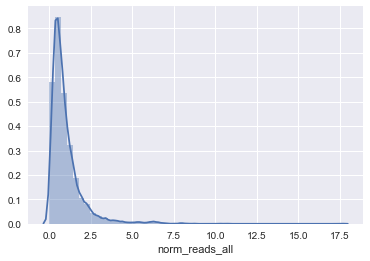

In [45]:
sns.distplot(chrom5["norm_reads_all"])
plt.show() 

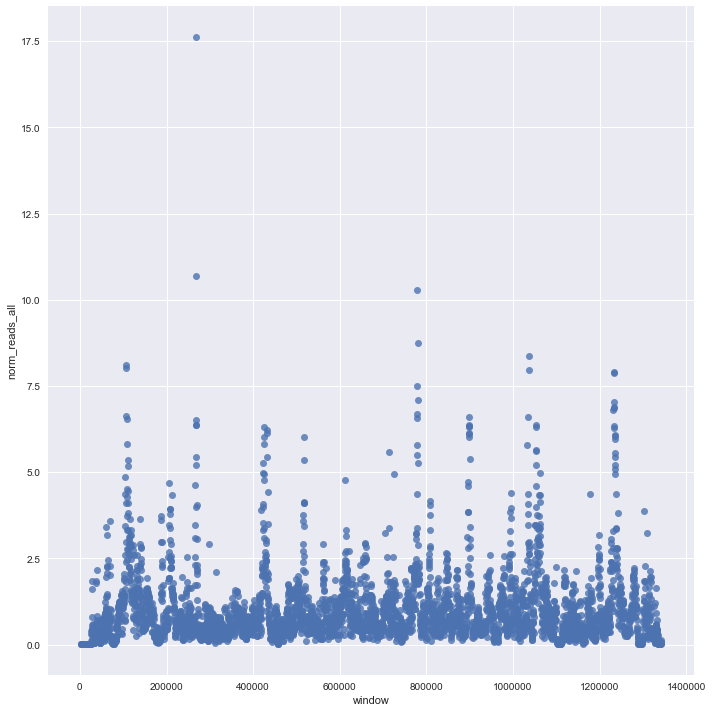

In [46]:
%matplotlib inline


# sns.set_style('ticks')
# fig, ax = plt.subplots()
# # the size of A4 paper
# fig.set_size_inches(3, 7)
sns.lmplot(x="window", y="norm_reads_all", data=chrom5, fit_reg=False, size=10)
plt.show()       

In [47]:

def fit_hmm(depth_normed,  # normalised coverage array 
            transition_probability,  # probability of state transition
            variance,  # variance per copy 
            variance_fixed,  # variance for the zero copy number state 
            min_copy_number=0,  # minimum copy number to consider in the model
            max_copy_number=5,  # maximum copy number to consider in the model 
            n_iter=0,  # number of iterations to perform when fitting the model
            params='st',  # parameters that can be changed through fitting 
            init_params='',  # parameters that are initialised from the data
           ):
    
    # convenience variable
    n_states = max_copy_number - min_copy_number
    
    # construct the transition matrix
    transmat = np.zeros((n_states, n_states))
    transmat[:] = transition_probability
    transmat[np.diag_indices(n_states)] = 1-((n_states-1)*transition_probability)
    display("transmat")
    display(transmat)

    # construct means and covariance
    means = np.array([[n] for n in range(min_copy_number, max_copy_number)])
    covars = np.array([[variance*n + variance_fixed] for n in range(min_copy_number, max_copy_number)])

    # setup HMM 
    model = hmm.GaussianHMM(n_states, 
                        covariance_type='diag', 
                        n_iter=n_iter, 
                        transmat_prior=transmat, 
                        params=params,
                        init_params=init_params)
    model.means_ = means
    model.covars_ = covars
    
    # fit HMM
    obs = np.column_stack([depth_normed])
    display("obs")
    display(obs)
#     obs = depth_normed
    model.fit(obs)
    
    # predict hidden states
    h = model.predict(obs)
    
    return h

In [48]:
display(chrom5["norm_reads_all"].values)
display(chrom5.shape)

array([ 0.00928881,  0.01567044,  0.00928881, ...,  0.05329649,
        0.06058922,  0.12492504])

(4405, 7)

In [49]:
copy_number = fit_hmm(depth_normed =chrom5["norm_reads_all"].values,  
                      transition_probability=.01,
                      variance=.1,
                      variance_fixed=.001)

'transmat'

array([[ 0.96,  0.01,  0.01,  0.01,  0.01],
       [ 0.01,  0.96,  0.01,  0.01,  0.01],
       [ 0.01,  0.01,  0.96,  0.01,  0.01],
       [ 0.01,  0.01,  0.01,  0.96,  0.01],
       [ 0.01,  0.01,  0.01,  0.01,  0.96]])

'obs'

array([[ 0.00928881],
       [ 0.01567044],
       [ 0.00928881],
       ..., 
       [ 0.05329649],
       [ 0.06058922],
       [ 0.12492504]])

/Users/tn6/anaconda3/envs/analysis_py35_mac/lib/python3.5/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


In [50]:

display(scipy.stats.describe(copy_number))
display(copy_number.shape)
display(copy_number[:10])

DescribeResult(nobs=4405, minmax=(0, 4), mean=1.2267877412031782, variance=0.50736581438193118, skewness=2.132326896204598, kurtosis=5.587714288478269)

(4405,)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

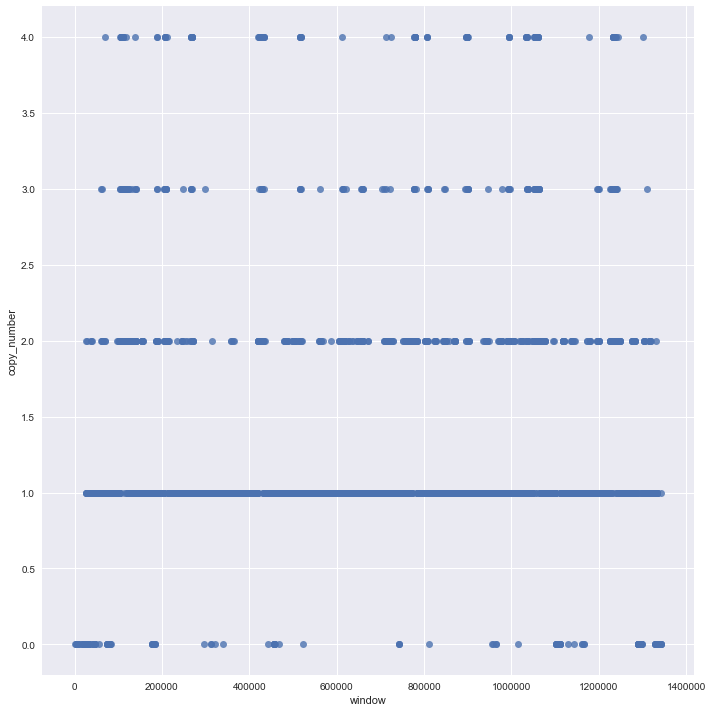

In [51]:
chrom5["copy_number"] = copy_number
# sns.set_style('ticks')
# fig, ax = plt.subplots()
# # the size of A4 paper
# fig.set_size_inches(3, 7)
sns.lmplot(x="window", y="copy_number", data=chrom5, fit_reg=False, size=10)


plt.show() 